# preparations

## imports


In [1]:
# environment imports
import sys, os, shutil, glob, time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data processing imports
import pandas as pd
import numpy as np

import cv2
from facenet_pytorch import MTCNN
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import librosa, fairseq
import soundfile as sf
from dataclasses import dataclass

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

## variables

In [38]:
DATA_DIR, LOCAL_DIR, FE_MODELS_DIR = './data', './', './models/feature_extractors'

TRAIN_MP4_DIR, TRAIN_WAV_DIR = f'{DATA_DIR}/train/mp4', f'{DATA_DIR}/train/wav'
VALID_MP4_DIR, VALID_WAV_DIR = f'{DATA_DIR}/val/mp4', f'{DATA_DIR}/val/wav'

TRAIN_MP4_FEATURES_DIR, TRAIN_WAV_FEATURES_DIR = f'{DATA_DIR}/train/mp4_features', f'{DATA_DIR}/train/wav_features'
VALID_MP4_FEATURES_DIR, VALID_WAV_FEATURES_DIR = f'{DATA_DIR}/val/mp4_features', f'{DATA_DIR}/val/wav_features'

In [39]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [40]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
mtcnn = MTCNN(keep_all=True, post_process=False, min_face_size=40, device=DEVICE, select_largest=True)
print(f'Current connected device is {DEVICE}')

Current connected device is cuda


## classes

In [41]:
@dataclass
class UserDirModule:
    user_dir: str

## functions

In [79]:
def configure_feature_extraction_model_visual(
    feature_extractor_model_path: str=None, device: torch.device=None, return_initial: bool=True
) -> np.ndarray:
    '''
    Function configure feature-extraction model
    
            Parameters:
                extraction_model_path (str): path to feature-extraction model;
                device (torch.device): torch device (default=torch.cuda);
                return_initial (bool): Return the initial model or not
            Returns:
                features-extraction model
    '''
    feature_extractor_model = torch.load(feature_extractor_model_path)
    feature_extractor_model.classifier = torch.nn.Identity()
    feature_extractor_model.to(device)
    feature_extractor_model.eval()

    if return_initial:
        return feature_extractor_model, torch.load(feature_extractor_model_path)
    else:
        return feature_extractor_model
    
def configure_emotion2vec_feature_extractor_model(
    emotion2vec_model_dir: str=None, emotion2vec_model_checkpoint: str=None, device: torch.device=None                                      
):
    '''
    Function cofigureates emotion2vec as feature extractor model.
    
            Parameters:
                emotion2vec_model_dir (str): Path to the emotion2vec directory;
                emotion2vec_model_checkpoint (str): Path to the model checkpoint;
                device (torch.device): Available torch device;
    '''
    emotion2vec_model_path = UserDirModule(emotion2vec_model_dir)
    fairseq.utils.import_user_module(emotion2vec_model_path)
    emotion2vec_checkpoint = emotion2vec_model_checkpoint

    emotion2vec_model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([emotion2vec_checkpoint])
    emotion2vec_model = emotion2vec_model[0].eval()
    emotion2vec_model = emotion2vec_model.to(device)
    
    return emotion2vec_model, cfg, task

def square_area(x1: float=None, y1: float=None, x2: float=None, y2: float=None):
    """
    Calculate the area of a square given the coordinates of two opposite vertices.
    
    Parameters:
        x1, y1: Coordinates of the first vertex.
        x2, y2: Coordinates of the second vertex.
        
    Returns:
        Area of the square.
    """
    # Ensure the points form a square (opposite sides are equal)
    side1 = abs(x2 - x1)
    side2 = abs(y2 - y1)
    
    area = side1 * side2
    return area

class FaceAligner:
    def __init__(self, desiredLeftEye=(0.30, 0.30)):
        self.desiredLeftEye = desiredLeftEye
        
    def align(
        self, image: np.ndarray=None, left_eye: np.ndarray=None, 
        right_eye: np.ndarray=None, width: int=None, height: int=None
    ):
        
        # compute the angle between the eye centroids
        dY = right_eye[1] - left_eye[1]
        dX = right_eye[0] - left_eye[0]
        angle = np.degrees(np.arctan2(dY, dX))
        
        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]
        
        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= width
        scale = desiredDist / dist
        
        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = (
            int((left_eye[0] + right_eye[0]) // 2),
            int((left_eye[1] + right_eye[1]) // 2)
        )
        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
        # update the translation component of the matrix
        tX = width * 0.5
        tY = height * self.desiredLeftEye[1]

        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])
        
        # apply the affine transformation
        output = cv2.warpAffine(image, M, (width, width), flags=cv2.INTER_CUBIC)
        
        return output
    
def detect_face_and_align(face_recongizer: MTCNN=None, frame=None, face_aligner: FaceAligner=None) -> np.ndarray:
    '''
    Function that detect face in the particular frame.
    
            Parameters:
                face_recognizer (MTCNN): MTCNN;
                frame: current frame of particular video;
                face_aligner (FaceAligner): Current FaceAligner algorithm
            Returns:
                face_image: numpy ndarrray;
    '''
    bounding_boxes, probs, landmarks = face_recongizer.detect(frame, landmarks=True)
    if None in probs: return False, False
    aligned_face_image, box = False, False
    if probs is None: return False, False
    else:
        bounding_boxes = bounding_boxes[probs > 0.9]
        landmarks = landmarks[probs > 0.9]
        if bounding_boxes == []: return False
        
        for bbox, landmark in zip(bounding_boxes, landmarks):
            box = bbox.astype(int)
            x1, y1, x2, y2 = box[:4]
            
            cropped_square_area = square_area(x1, y1, x2, y2)
            if cropped_square_area is None:
                continue
                
            left_eye_landmark, right_eye_landmark = landmark[0], landmark[1]
            width, height = abs(x1 - x2), abs(y1 - y2)
            aligned_face_image = face_aligner.align(frame, left_eye_landmark, right_eye_landmark, width, height)
        
        return aligned_face_image

def detect_face(face_recongizer: MTCNN=None, frame=None) -> np.ndarray:
    '''
    Function that detect face in the particular frame.
    
            Parameters:
                face_recognizer (MTCNN): MTCNN;
                frame: current frame of particular video;
            Returns:
                face_image: numpy ndarrray;
    '''
    bounding_boxes, probs = face_recongizer.detect(frame, landmarks=False)
    if None in probs: return False, False
    face_image, box = False, False
    if probs is None: return False, False
    else:
        bounding_boxes = bounding_boxes[probs > 0.9]
        if bounding_boxes == []: return False
        for bbox in bounding_boxes:
            box = bbox.astype(int)
            x1, y1, x2, y2 = box[:4]
            
            cropped_square_area = square_area(x1, y1, x2, y2)
            if cropped_square_area is None:
                continue
            
            face_image = frame[y1:y2, x1:x2, :]
            break
        return face_image, box
    
def crop_image(frame: np.ndarray=None, box: list=None):
    """
    Function crops image by bounding boxes.
    
            Parameters:
                frame (np.ndarray): Current image;
                box (list): Current bboxes.
    """
    x1, y1, x2, y2 = box[:4]
    cropped_image = frame[y1:y2, x1:x2, :]
    
    return cropped_image

def extract_visual_features(
    data_info: pd.DataFrame=None, mp4_dir: str=None, dir_to_save: str=None, device: torch.device=None, 
    mtcnn: MTCNN=None, feature_extractor_model: timm.models.efficientnet.EfficientNet=None, 
    image_transforms: transforms=None, stride: int=None, keep_all: bool=False, face_aligner: FaceAligner=None
) -> None:
    '''
    Funcction that extract features from videos using FE model.
    
            Parameters:
                data_info (pd.DataFrame): Frame of video characteristics;
                mp4_dir (str): Directory of video files;
                dir_to_save (str): Directory name, where features will be saved;
                device (torch.device): Available torch device;
                mtcnn (MTCNN): Face recognizer algorithm;
                feature_extractor_model (timm.models.efficientnet.EfficientNet): Model for feature extraction;
                image_transforms (transforms): Transforms, which will be applied on frames;
    '''
    if not os.path.exists(dir_to_save):
        os.mkdir(dir_to_save)
    print(f'All features will be stored at {dir_to_save}')
        
    for current_file_name in tqdm(os.listdir(mp4_dir)):
        current_frames, current_batch = [], 0
        current_file_path = f'{mp4_dir}/{current_file_name}'
                
        if current_file_name.endswith(".mp4"):
            batches_folder_path = f'{dir_to_save}/{current_file_name.replace(".mp4", "")}_batched_features'
            
            if not os.path.exists(batches_folder_path):
                os.mkdir(batches_folder_path)
            else:
                continue
            vid, frames_count = cv2.VideoCapture(current_file_path), 0
            
            while (True):
                success, frame = vid.read()
                if not success: break
                    
                if ((frames_count % stride == 0) or (frames_count == 0)):
                    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    if face_aligner is not None:
                        cropped_aligned_face = detect_face_and_align(
                            face_recongizer=mtcnn, frame=rgb_frame, face_aligner=face_aligner)
                    else:
                        cropped_aligned_face = detect_face(face_recongizer=mtcnn, frame=rgb_frame)
                    if ((isinstance(cropped_aligned_face, np.ndarray)) and (0 not in cropped_aligned_face.shape)):
                        current_frames.append(image_transforms(cropped_aligned_face))

                        if len(current_frames) >= 64: 
                            current_frames = torch.stack(current_frames, dim=0).to(device)
                            batch_features = feature_extractor_model(current_frames)
                            batch_features = batch_features.data.cpu().numpy()

                            batch_features_file_path = f'{batches_folder_path}/batch={current_batch}.npy'
                            with open(batch_features_file_path, 'wb') as f: np.save(f, batch_features)

                            current_frames = []
                            current_batch += 1
                frames_count += 1
                
            if len(current_frames):
                current_frames = torch.stack(current_frames, dim=0).to(device)
                
                batch_features = feature_extractor_model(current_frames)
                batch_features = batch_features.data.cpu().numpy()
                batch_features_file_path = f'{batches_folder_path}/batch={current_batch}.npy'
                with open(batch_features_file_path, 'wb') as f: np.save(f, batch_features)

                current_frames = []
                
        del vid
        torch.cuda.empty_cache()
        
def stack_npy_files(directory: str=None):
    """
    Open all .npy files in the given directory and stack them into one big array.
    
            Parameters:
                directory (str): The directory containing the .npy files.
    """
    npy_files = [file for file in os.listdir(directory) if file.endswith('.npy')]
    if not npy_files:
        print("No .npy files found in the directory.")
        return None
    
    stacked_array = np.concatenate([np.load(os.path.join(directory, file)) for file in npy_files], axis=0)
    return stacked_array

def extract_acoustic_features(
    data_info: pd.DataFrame=None, wav_dir: str=None, dir_to_save: str=None, device: torch.device=None,
    feature_extractor_model=None, feature_extractor_model_task: dict=None, mode: str=None, visual_features_dir: str=None,
    granularity: str='frame'
) -> None:
    """
    Function extracts features from the .wav files and save them locally.
    
            Parameters:
                data_info (pd.DataFrame): Frame of video characteristics;
                wav_dir (str): Directory of acoustic files;
                dir_to_save (str): Directory name, where features will be saved;
                device (torch.device): Available torch device;
                features-extraction model: Current feature-extraction model if neccessary;
                mode (str): Current mode ("feature-extraction-model", "mfcc")
    """
    if not os.path.exists(dir_to_save):
        os.mkdir(dir_to_save)
    print(f'All features will be stored at {dir_to_save}')
    
    for current_file_name in tqdm(os.listdir(wav_dir), desc=f"extracting {mode} features"):
        current_file_path = f'{wav_dir}/{current_file_name}'

        if current_file_name.endswith('.wav'):
            features_folder_path = f'{dir_to_save}/{current_file_name.replace(".wav", "")}_features'
            if not os.path.exists(features_folder_path):
                os.mkdir(features_folder_path)
                
            acoustic_features_file_path = f'{features_folder_path}/{mode}_features.npy'
            if os.path.exists(acoustic_features_file_path): continue
            
            visual_modality_dir_path = f'{visual_features_dir}/{current_file_name.replace(".wav", "")}_batched_features'
            if len(os.listdir(visual_modality_dir_path)) < 1: continue
            stacked_visual_features = stack_npy_files(directory=visual_modality_dir_path)
            
            if mode == 'mfcc':
                visual_feature_length = stacked_visual_features.shape[0]
                feature_channels = 1024
                
                y, sr = librosa.load(current_file_path, sr=None)
                audio_mfccs = librosa.feature.mfcc(
                    y=y, sr=sr, n_mfcc=128, n_fft=512, hop_length=240, pad_mode='reflect', htk=True)
                
                audio = audio_mfccs.reshape(-1,)
                while len(audio) <= feature_channels * 40:
                    audio = np.append(audio, audio)
                
                audio_features = audio[8 * feature_channels: 40 * feature_channels]
                audio_features = audio_features.reshape(feature_channels, -1)
                audio_features = audio_features.transpose(1, 0)
                
            elif mode == 'feature-extraction-model': # assuming we have emotion2vec as feature extractor
                visual_feature_length = stacked_visual_features.shape[0]
                
                wav, sampling_rate = sf.read(current_file_path)
                channel = sf.info(current_file_path).channels
                assert sampling_rate == 16e3, f"Sample rate should be 16kHz, but got {sampling_rate} in file {current_file_path}"
                assert channel == 1, f"Channel should be 1, but got {channel} in file {current_file_path}"
                
                with torch.no_grad():
                    source = torch.from_numpy(wav).float().cuda()
                    if feature_extractor_model_task.cfg.normalize: source = F.layer_norm(source, source.shape)
                    source = source.view(1, -1)

                    try:
                        audio_features = feature_extractor_model.extract_features(source, padding_mask=None)
                        audio_features = audio_features['x'].squeeze(0).cpu().numpy()

                        if granularity == 'frame': audio_features = audio_features
                        elif granularity == 'utterance': audio_features = np.mean(audio_features, axis=0)
                        else: raise ValueError("Unknown granularity: {}".format(granularity))
                            
                    except:
                        Exception("Error in extracting features from {}".format(current_file_path))
                        
            elif mode == 'deepspectrum':
                os.chdir('./DeepSpectrum')
                cmd = f"deepspectrum features {current_file_path}  -nl -en densenet121 -fl avg_pool -m mel -o {acoustic_features_file_path.replace('.npy', '.csv')}"
                os.system(cmd)
                
            elif mode == 'custom':
                y, sr = librosa.load(current_file_path, sr=None)
                audio_features = whole_audio_features(y, sr).reshape(1, -1)
                
            if mode != 'deepspectrum':
                with open(acoustic_features_file_path, 'wb') as f:
                        np.save(f, audio_features)

## face-align example

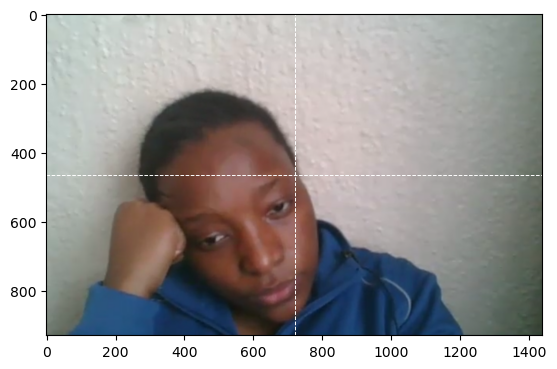

In [80]:
not_aligned_image = cv2.imread('./not_aligned.png')
not_aligned_image = cv2.cvtColor(not_aligned_image, cv2.COLOR_BGR2RGB)
plt.imshow(not_aligned_image)

plt.axvline(not_aligned_image.shape[1] // 2, color='white', linewidth=.7, linestyle='--')
plt.axhline(not_aligned_image.shape[0] // 2, color='white', linewidth=.7, linestyle='--')

# plt.savefig('./not_aligned_plt.png', dpi=150)
plt.show()

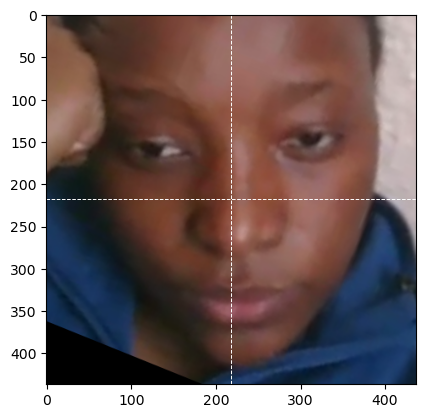

In [81]:
face_aligner = FaceAligner()
cropped_aligned_face = detect_face_and_align(face_recongizer=mtcnn, frame=not_aligned_image, face_aligner=face_aligner)
plt.imshow(cropped_aligned_face)

plt.axvline(cropped_aligned_face.shape[1] // 2, color='white', linewidth=.7, linestyle='--')
plt.axhline(cropped_aligned_face.shape[0] // 2, color='white', linewidth=.7, linestyle='--')

# plt.savefig('./aligned_plt.png', dpi=150)
plt.show()

# Feature-extracion

## visual modality

In [82]:
start_time_extraction = time.time()

efficientnetb0_feature_extractor = configure_feature_extraction_model_visual(
    feature_extractor_model_path=f'{FE_MODELS_DIR}/efficientnet_affectnet.pt', device=DEVICE, return_initial=False)
face_aligner = FaceAligner()

extract_visual_features(
    mp4_dir=TRAIN_MP4_DIR, dir_to_save=TRAIN_MP4_FEATURES_DIR + '-HSEmotion-aligned', device=DEVICE, 
    mtcnn=mtcnn, feature_extractor_model=efficientnetb0_feature_extractor, image_transforms=image_transforms,
    stride=5, face_aligner=face_aligner
)
extract_visual_features(
    mp4_dir=VALID_MP4_DIR, dir_to_save=VALID_MP4_FEATURES_DIR + '-HSEmotion-aligned', device=DEVICE, 
    mtcnn=mtcnn, feature_extractor_model=efficientnetb0_feature_extractor, image_transforms=image_transforms,
    stride=5, face_aligner=face_aligner
)

elapsed_time = time.time() - start_time_extraction
print(f'All features were extracted in {np.round((elapsed_time/3600), 0)} hours')

All features will be stored at ./data/train/mp4_features-HSEmotion-aligned


  0%|          | 0/15806 [00:00<?, ?it/s]

All features will be stored at ./data/val/mp4_features-HSEmotion-aligned


  0%|          | 0/4657 [00:00<?, ?it/s]

All features were extracted in 12.0 hours


## acoustic modality

In [8]:
emotion2vec_model, cfg, task = configure_emotion2vec_feature_extractor_model(
    emotion2vec_model_dir=r'../diploma_work_abaw/emotion2vec/upstream', 
    emotion2vec_model_checkpoint=f'{FE_MODELS_DIR}/emotion2vec_base.pt', device=DEVICE
)

In [15]:
start_time_extraction = time.time()

for mode in ['mfcc', 'feature-extraction-model']:
    extract_acoustic_features(
        wav_dir=TRAIN_WAV_DIR, dir_to_save=TRAIN_WAV_FEATURES_DIR, device=DEVICE, 
        visual_features_dir=TRAIN_MP4_FEATURES_DIR + '-HSEmotion', mode=mode,
        feature_extractor_model=emotion2vec_model, feature_extractor_model_task=task
    )
    extract_acoustic_features(
        wav_dir=VALID_WAV_DIR, dir_to_save=VALID_WAV_FEATURES_DIR, device=DEVICE, 
        visual_features_dir=VALID_MP4_FEATURES_DIR + '-HSEmotion', mode=mode,
        feature_extractor_model=emotion2vec_model, feature_extractor_model_task=task
    )

elapsed_time = time.time() - start_time_extraction
print(f'All features were extracted in {np.round((elapsed_time/60), 0)} minutes')

All features will be stored at ./data/train/wav_features


  0%|          | 0/15806 [00:00<?, ?it/s]

All features will be stored at ./data/val/wav_features


  0%|          | 0/4657 [00:00<?, ?it/s]

All features were extracted in 32.0 minutes


In [9]:
start_time_extraction = time.time()

for mode in ['feature-extraction-model']:
    extract_acoustic_features(
        wav_dir=TRAIN_WAV_DIR, dir_to_save=TRAIN_WAV_FEATURES_DIR + f'-{mode}', device=DEVICE, 
        visual_features_dir=TRAIN_MP4_FEATURES_DIR + '-HSEmotion', mode=mode,
        feature_extractor_model=emotion2vec_model, feature_extractor_model_task=task, granularity='frame'
    )
    extract_acoustic_features(
        wav_dir=VALID_WAV_DIR, dir_to_save=VALID_WAV_FEATURES_DIR + f'-{mode}', device=DEVICE, 
        visual_features_dir=VALID_MP4_FEATURES_DIR + '-HSEmotion', mode=mode,
        feature_extractor_model=emotion2vec_model, feature_extractor_model_task=task, granularity='frame'
    )

elapsed_time = time.time() - start_time_extraction
print(f'All features were extracted in {np.round((elapsed_time/60), 0)} minutes')

All features will be stored at ./data/train/wav_features-feature-extraction-model


extracting feature-extraction-model features:   0%|          | 0/15806 [00:00<?, ?it/s]

All features will be stored at ./data/val/wav_features-feature-extraction-model


extracting feature-extraction-model features:   0%|          | 0/4657 [00:00<?, ?it/s]

All features were extracted in 23.0 minutes


In [69]:
start_time_extraction = time.time()

for mode in ['mfcc']:
    extract_acoustic_features(
        wav_dir=TRAIN_WAV_DIR, dir_to_save=TRAIN_WAV_FEATURES_DIR + f'-{mode}', device=DEVICE, 
        visual_features_dir=TRAIN_MP4_FEATURES_DIR + '-HSEmotion', mode=mode
    )
    extract_acoustic_features(
        wav_dir=VALID_WAV_DIR, dir_to_save=VALID_WAV_FEATURES_DIR + f'-{mode}', device=DEVICE, 
        visual_features_dir=VALID_MP4_FEATURES_DIR + '-HSEmotion', mode=mode
    )

elapsed_time = time.time() - start_time_extraction
print(f'All features were extracted in {np.round((elapsed_time/60), 0)} minutes')

All features will be stored at ./data/train/wav_features-mfcc


extracting mfcc features:   0%|          | 0/15806 [00:00<?, ?it/s]

All features will be stored at ./data/val/wav_features-mfcc


extracting mfcc features:   0%|          | 0/4657 [00:00<?, ?it/s]

All features were extracted in 9.0 minutes


In [17]:
start_time_extraction = time.time()

for mode in ['custom']:
    extract_acoustic_features(
        wav_dir=TRAIN_WAV_DIR, dir_to_save=TRAIN_WAV_FEATURES_DIR + f'-{mode}', device=DEVICE, 
        visual_features_dir=TRAIN_MP4_FEATURES_DIR + '-HSEmotion', mode=mode
    )
    extract_acoustic_features(
        wav_dir=VALID_WAV_DIR, dir_to_save=VALID_WAV_FEATURES_DIR + f'-{mode}', device=DEVICE, 
        visual_features_dir=VALID_MP4_FEATURES_DIR + '-HSEmotion', mode=mode
    )

elapsed_time = time.time() - start_time_extraction
print(f'All features were extracted in {np.round((elapsed_time/60), 0)} minutes')

All features will be stored at ./data/train/wav_features-custom


extracting custom features:   0%|          | 0/15806 [00:00<?, ?it/s]

All features will be stored at ./data/val/wav_features-custom


extracting custom features:   0%|          | 0/4657 [00:00<?, ?it/s]

All features were extracted in 55.0 minutes
